In [165]:
include("goddard_hermite-Simpson.jl")
include("goddard.jl")
include("goddard.jl")
include("goddard_Euler.jl")
using NLPModels
using NLPModelsIpopt
using NLPModelsJuMP
using SparseArrays
using SuiteSparse

using Plots
function normalize_matrix(mat)
    min_val = minimum(mat)
    max_val = maximum(mat)
    (mat .- min_val) ./ (max_val - min_val)
end

function present_Heatmap(Mat,name="")
    norm_matrix = normalize_matrix(Mat)
    max_Mat = round(maximum(Mat),sigdigits = 4)
    min_Mat = round(minimum(Mat),sigdigits = 4)
    Lims = "[$min_Mat,$max_Mat]"
    heatmap(norm_matrix, color=:grays, 
            #clims =(min_Mat,max_Mat) ,
            xlabel="Columns", ylabel="Rows", title="Matrix Heatmap $name $Lims")
end

present_Heatmap (generic function with 2 methods)

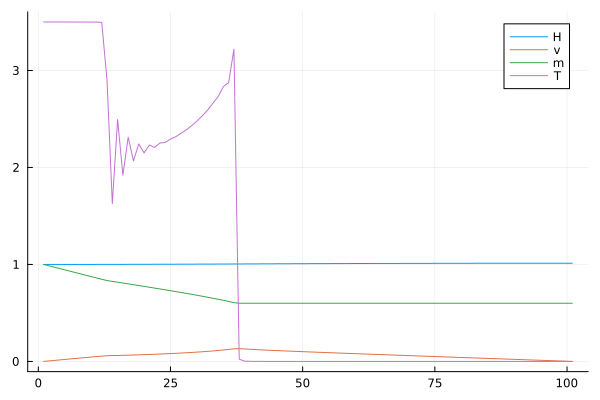

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4900

Total number of variables............................:      405
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0100000e+00 3.50e-02 1.63e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

6×405 Matrix{Float64}:
 -1.0  -1.0  -1.0  -1.0  -1.0  0.0  0.0  …   0.0   0.0   0.0   0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0   0.0   0.0   0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0   0.0   0.0   0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0  0.0     -1.0  -1.0  -1.0  -1.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0  0.0      0.0   0.0   0.0   0.0  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  0.0  0.0  …   0.0   0.0   0.0   0.0  0.0  0.0

In [192]:
nh = 100
model = rocket_model(nh)
nlp = MathOptNLPModel(model)
res = ipopt(nlp)

ind_h = 1:101
ind_v = 102:202
ind_m = 203:303
ind_T = 304:404
Lim_l_h = 1.0
Lim_l_v = 0.0
Lim_l_m = 0.6
Lim_l_T = 0.0
Lim_u_m = 1.0
Lim_u_T = 3.5*1.0*1.0
tol = 1e-4

I_l = zeros(4,405)
I_u = zeros(2,405)

sol_h = res.solution[ind_h]
sol_v = res.solution[ind_v]
sol_m = res.solution[ind_m]
sol_T = res.solution[ind_T]

p = Plots.plot(sol_h,label = "H")
Plots.plot!(sol_v,label = "v")
Plots.plot!(sol_m,label = "m")
Plots.plot!(sol_T,label  = "T")
Plots.display(p)

I_l[1,ind_h] = -(abs.(sol_h .- Lim_l_h).<= tol) .+ 0 
I_l[2,ind_v] = -(abs.(sol_v .- Lim_l_v).<= tol) .+ 0 
I_l[3,ind_m] = -(abs.(sol_m .- Lim_l_m).<= tol) .+ 0 
I_l[4,ind_T] = -(abs.(sol_T .- Lim_l_T).<= tol) .+ 0 
I_u[1,ind_m] = (abs.(sol_m .- Lim_u_m).<= tol) .+ 0
I_u[2,ind_T] = (abs.(sol_T .- Lim_u_T).<= tol) .+ 0

# Limvec_l = [Lim_l_h,Lim_l_v,Lim_l_m,Lim_l_T]
# Limvec_u = [Lim_u_m,Lim_u_T]
# for i in range(1,101)
#     paras = [sol_h[i],sol_v[i],sol_m[i],sol_T[i]]
#     diff_l = abs.(paras - Limvec_l)
#     diff_u = abs.(paras[3:4] - Limvec_u)
#     I_l[:,i] = -(diff_l .<= tol) .+ 0 
#     I_u[:,i] = (diff_u .<= tol) .+ 0 
# end

I_lu = vcat(I_l,I_u)

In [200]:
sol_h

101-element Vector{Float64}:
 1.0
 1.0000049778553994
 1.0000199786667812
 1.000045107096471
 1.0000804084858443
 1.0001258711615373
 1.000181431887341
 1.0002469840326857
 1.0003223877494694
 1.0004074812777848
 ⋮
 1.0127070859413803
 1.012736137396049
 1.0127613374736397
 1.0127826865499268
 1.0128001849428367
 1.012813832915589
 1.0128236306813365
 1.0128295784155936
 1.012831676352105

In [193]:
# Get primal-dual solution
x = res.solution
y = res.multipliers

n = NLPModels.get_nvar(nlp)
m = NLPModels.get_ncon(nlp)

# Build sparse Hessian 
nnzh = NLPModels.get_nnzh(nlp)
Wi, Wj = NLPModels.hess_structure(nlp)
Wz = zeros(nnzh)
NLPModels.hess_coord!(nlp, x, y, Wz)
W = sparse(Wi, Wj, Wz, n, n)

# Build sparse Jacobian 
nnzj = NLPModels.get_nnzj(nlp)
Ji, Jj = NLPModels.jac_structure(nlp)
Jz = zeros(nnzj)
NLPModels.jac_coord!(nlp, x, Jz)
J = sparse(Ji, Jj, Jz, m, n)
J1 = Matrix(J)
J_act = vcat(J1,I_lu)
J_act
println("Added $(size(J_act)[1]-size(J1)[1]) lines to formal Jacobian as real inequal constrains")
present_Heatmap(J_act)

Added 6 lines to formal Jacobian as real inequal constrains


In [195]:
using LinearAlgebra
Z = nullspace(J_act)

405×96 Matrix{Float64}:
  0.0          0.0           0.0          …   0.0          0.0
 -2.10956e-7   2.6852e-8     4.15373e-8       1.24326e-7  -2.09609e-7
 -3.97831e-7   7.21695e-8    1.01318e-7       2.27624e-7  -6.23042e-7
 -6.52948e-8   1.79123e-8    2.359e-8         4.13467e-8  -2.51569e-7
  6.74081e-7  -1.16934e-7   -1.66445e-7      -3.93297e-7   1.08422e-6
  1.45712e-6  -2.37127e-7   -3.49785e-7   …  -8.73975e-7   2.02126e-6
  2.032e-6    -5.00371e-7   -6.10886e-7      -1.29595e-6   1.91198e-6
  2.4167e-6    7.28211e-8   -9.85762e-7      -1.80573e-6   1.41846e-6
  2.73415e-6   2.62602e-6   -3.5407e-7       -2.39001e-6   1.01118e-6
  3.10983e-6   6.06263e-6    2.31419e-6      -2.93914e-6   6.13019e-7
  ⋮                                       ⋱                ⋮
 -0.0997176   -0.00102904    0.00526778      -0.053181     0.00636694
  0.10059      0.00699275    0.000898756     -0.0378813   -0.00423156
 -0.0533535    0.000826545   0.0042574       -0.0537021    0.00670372
 -0.114703  

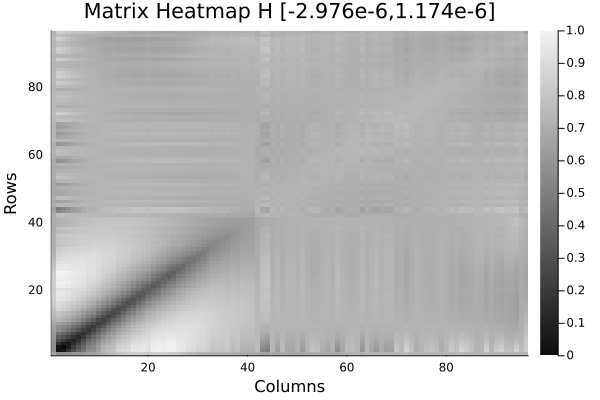

In [196]:
H = Z'*Symmetric(W, :L)*Z
present_Heatmap(H,"H")

In [190]:
J* Z

304×100 Matrix{Float64}:
  0.0           0.0           0.0          …   0.0           0.0
 -1.49891e-17   5.67851e-18   3.5694e-18      -3.71847e-19   6.93858e-18
  2.94602e-17  -3.97449e-18  -2.17582e-18      4.00726e-18   4.82822e-17
 -2.22117e-17   1.23222e-17   5.81996e-18     -7.0137e-18   -9.07528e-17
 -2.50139e-20   1.74701e-20   6.61083e-21      2.73631e-21   5.31116e-20
 -2.4871e-19    1.16467e-20   5.29396e-20  …  -1.50348e-20  -1.18267e-19
 -2.34628e-19  -2.17899e-19   9.26707e-20     -3.66606e-20   1.67183e-19
 -2.75646e-18   1.03783e-18  -3.43763e-19      1.61201e-20  -1.12327e-18
  5.21349e-18  -1.13502e-19  -7.61112e-19     -1.45266e-19  -1.60036e-18
  6.11558e-18  -2.52564e-18   1.29638e-18     -2.54375e-19   7.85136e-18
  ⋮                                        ⋱                
  7.64363e-18  -2.77149e-18  -7.26754e-19  …   6.11558e-19  -1.77572e-17
  7.61652e-18  -3.66596e-18   3.1679e-19      -2.93073e-19   5.32276e-18
  3.67273e-18   3.65241e-18  -5.67173e-18     

In [197]:
eigvals(H)

96-element Vector{Float64}:
 -2.43039779806629e-5
 -1.61717706899333e-5
 -6.319640818779207e-6
 -4.836553951644618e-6
 -2.727343155934444e-6
 -2.200647021281358e-6
 -1.4643998803793133e-6
 -1.2432092264215903e-6
 -9.04934700317698e-7
 -8.857328246732765e-7
  ⋮
  8.767601730936706e-8
  1.2420802039465985e-7
  1.373076150513156e-7
  2.160692064974477e-7
  2.488643877486003e-7
  4.6461469486529377e-7
  5.89058846102342e-7
  1.5356013351409165e-6
  2.6830024967086597e-6